Bibliotecas necessárias:

In [11]:
%matplotlib inline
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [13]:
## Simulador do Sinal de Saída     w[k] ---|h[k]|---->  r[k]
##  r[k] = w[k] * h[k] + n[k]

def sim_output_measurement(impulse_response, noise_samples=10000):

  w = np.random.normal(loc=0, scale=1, size=noise_samples)

  # convolve with the impulse response h[k]
  r_k = np.convolve(w, h, mode='full')

  #then, sum with the reading noise N - (0, 0.1) with the size of the convolution
  r_k = r_k[:noise_samples] + np.random.normal(loc=0, scale=0.1, size=noise_samples)

  return r_k, w

In [15]:
def estimation_error(estimator, reference):
  error = np.sum((reference - estimator) ** 2)/np.sum(reference ** 2)
  return error

In [30]:
def plot_estimators(estimated, real):
  plt.plot(real, label='Real');
  plt.plot(estimated, alpha=0.6, label='Estimated');
  plt.title("Impulse response comparison")
  plt.xlabel("samples")
  plt.ylabel("Amplitude")
  if len(estimated) > 1:
    plt.legend();
  plt.show();
  print("Erro do estimador de: {0:.3f} %".format(estimation_error(h_est, h)*100))

---


## Carregando o aúdio da responsa ao impulso

Fazendo a normalização da série e truncando em 6000 samples

In [12]:
audio_garrafa = "res/Garrafa.wav"

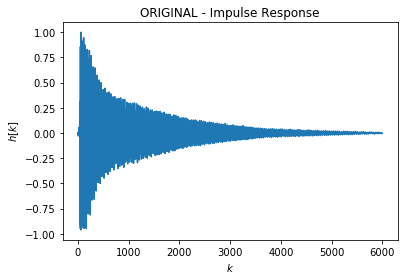

In [19]:
srate, h = wavfile.read(audio_garrafa)
h = h[:6000]/np.max(np.abs(h), axis=0)

plt.plot(h)
plt.title("ORIGINAL - Impulse Response")
plt.ylabel(r'$h[k]$')
plt.xlabel(r'$k$')
plt.show()

---

# 2 - Estimação por Correlação

## 2.1 - Demonstração

## 2.2 - O estimador

## 2.3 - Implementação

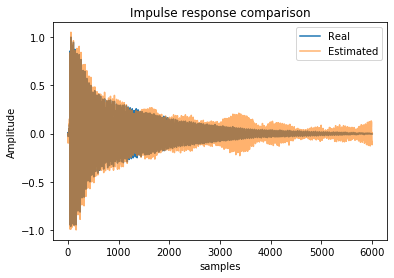

Erro do estimador de: 8.285 %


In [31]:
# Definindo o número de samples da nossa excitação
num_samples_excitation = 60000

# Pegando o sinal do output e o de entrada
r_k, w_noise = sim_output_measurement(h, num_samples_excitation)

#
#  Correlação cruzada entre a saída e a entrada
#

p_k = np.correlate(r_k, w_noise, 'full')
p_k = p_k/len(r_k)

#
#  Nosso primeiro estimador é dado abaixo
#

h_est =p_k[num_samples_excitation-1:num_samples_excitation+len(h)-1]

plot_estimators(h_est, h)

---

# 3 - Melhorando a estimação

---

# 4 - Mínimo Erro Quadrático Médio (MMSE)